In this kernel, we will apply a stroke classification with basic ml models. The outline of the project:
* Introduction
* Background and Motivation
* Packages & Libraries
* First look on the data
* Explatory Data Analysis
* Feature Engineering
* Encoding, Missing Value Imputation and Oversampling
* ML Models Building and Hyperparameter Tuning
* Model Evaluation

### Introduction
<img src="https://www.cdc.gov/stroke/images/Stroke-Medical-Illustration.jpg?_=77303?noicon">

### Background and Motivation

Background: A stroke, sometimes called a brain attack, occurs when something blocks blood supply to part of the brain or when a blood vessel in the brain bursts. Brain cells begin to die in minutes. A stroke is a medical emergency, and prompt treatment is crucial. A stroke can cause lasting brain damage, long-term disability, or even death. Early action can reduce brain damage and other complications.

Motivation: Our objective is to understand what are the reasons that cause stroke to people and see if we can succesfully detect stroke on the features from given data using ML techniques.

### Packages & Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### First Look on the Data

In [2]:
data = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# drop unnecessary columns
df.drop(["id"], axis = 1, inplace = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# data info: columns with data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
# bmi column seems it has null values. Let's check it out!
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

How many target variables of both "stroke" or "not stroke" classes on the dataset?

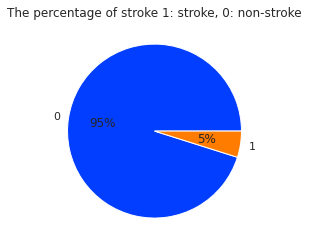

In [144]:
data = df["stroke"].value_counts()
labels = df["stroke"].value_counts().index

palette_color = sns.color_palette('bright')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title("The percentage of stroke 1: stroke, 0: non-stroke");

#### Issues:
There is 201 null BMI values on the dataset. Additionally the data is imbalance therefore we need to solve these issues for better results.

### Explatory Data Analysis (EDA)

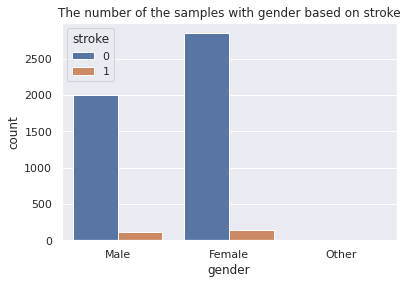

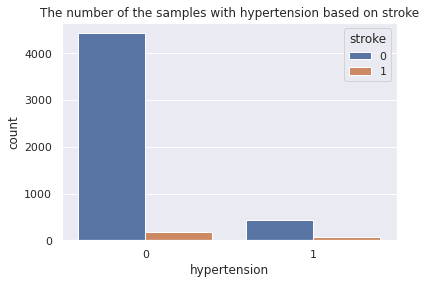

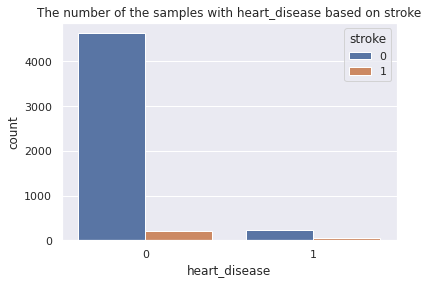

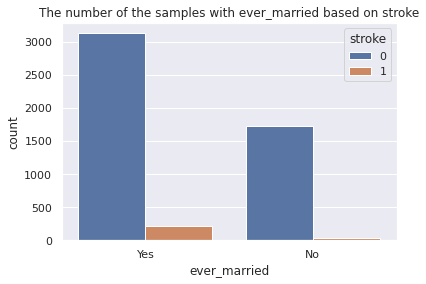

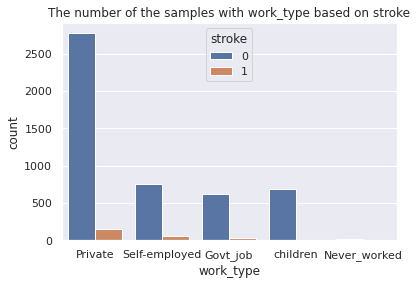

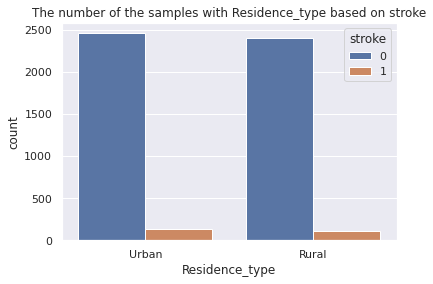

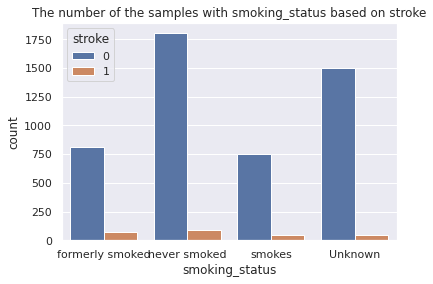

In [7]:
# a short look into the number of each categorical features grouped by stroke variable.
sns.set_theme(style = 'darkgrid')
for i in df.columns[:-1]:  # exclude stroke column
    if (df[i].dtype == 'object') or (df[i].dtype == 'int64'):
            sns.countplot(data = df, x = i, hue = 'stroke')
            plt.title('The number of the samples with {} based on stroke'.format(i))
            plt.show()

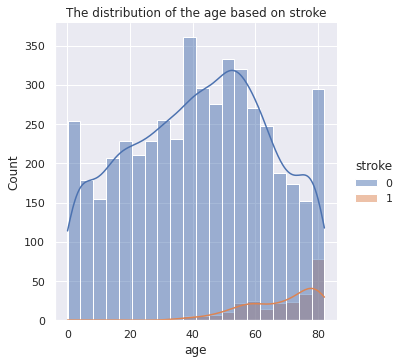

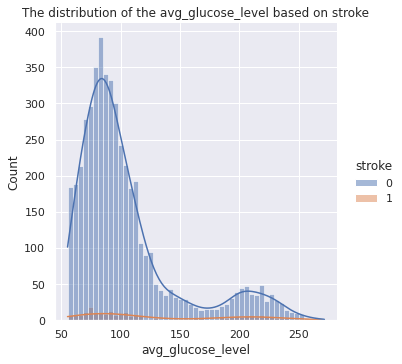

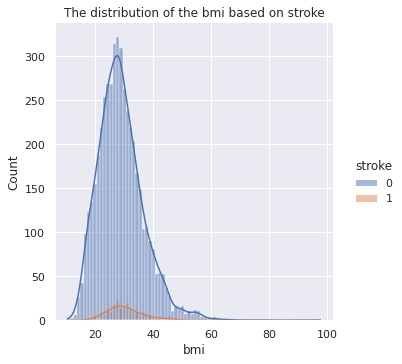

In [8]:
# a short look into numeric variables like bmi, avg_glucose_level and age
sns.set_theme(style = 'darkgrid')
for i in df.columns[:-1]: # exclude stroke column
    if df[i].dtype == 'float64':
            sns.displot(data = df, x = i, hue = 'stroke', kde = True)
            plt.title('The distribution of the {} based on stroke'.format(i))
            plt.show()

<AxesSubplot:>

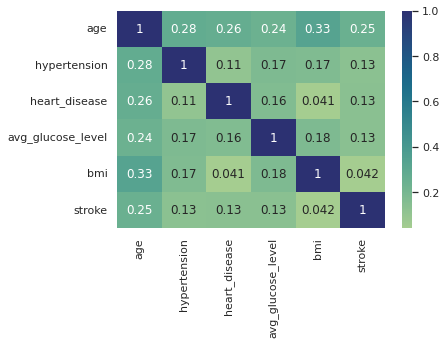

In [9]:
# Correlation heatmap
sns.heatmap(df.corr(), annot = True, cmap = 'crest')

### Feature Engineering
* Swarmplot, rugplot and kde plots to see the numeric variables' distributive differences between stroke or non-stroke conditions.
* Regression plots to see the relations between numeric variables like age, avg_glucose_level etc.
* Feature importance with Extra Tree Classifier

#### Önemli not: SMOTE ile oversampling yapıldıktan sonra data visualization tekrarlanacak.

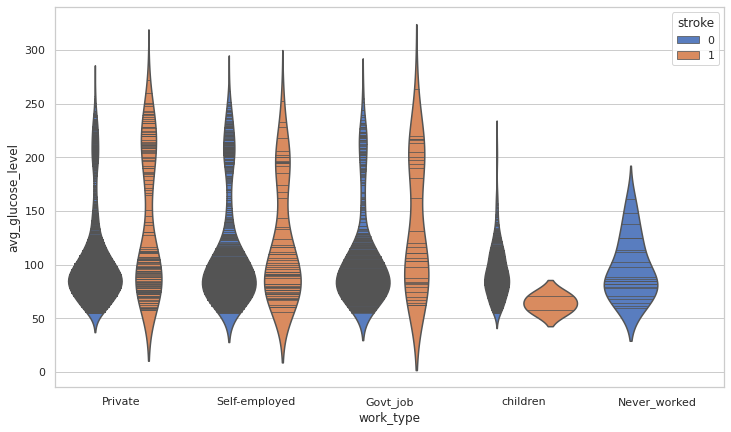

In [32]:
# Violin plot to visualize each numerical variables by stroke
plt.figure(figsize = (12, 7))
sns.violinplot(data = df, x = "work_type", y="avg_glucose_level", hue = 'stroke', inner = 'stick')
plt.show()

### Encoding, Missing Value Imputation and Oversampling

#### Encoding

In [459]:
# First we need to transform our columns to be encoded to numpy arrays
gender = df.iloc[:,0:1].values
ever_married = df.iloc[:,4].values  # reshaped 2d array for ordinal encoder
work_type = df.iloc[:,5:6].values
residence_type = df.iloc[:,6].values # reshaped 2d array for ordinal encoder
smoking_status = df.iloc[:,9:10].values

In [460]:
# Other variables
age = df[["age"]]
hypertension = df[["hypertension"]]
heart_disease = df[["heart_disease"]]
avg_glucose_level = df[["avg_glucose_level"]]
bmi = df[["bmi"]]
stroke = df[["stroke"]]

In [461]:
unique, counts = np.unique(ever_married, return_counts = True)
print(np.asarray((unique, counts)).T)

[['No' 1757]
 ['Yes' 3353]]


In [462]:
# Label Encoding for ever_married and residence_type columns which has two labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ever_married = le.fit_transform(ever_married)
ever_married = pd.DataFrame(ever_married, columns = ["ever_married"])
print("Labels 0, 1:",le.classes_)
residence_type = le.fit_transform(residence_type)
residence_type = pd.DataFrame(residence_type, columns = ["residence_type"])
print("Labels 0, 1:",le.classes_)

Labels 0, 1: ['No' 'Yes']
Labels 0, 1: ['Rural' 'Urban']


In [463]:
# One Hot Encoding for gender, work_type and smoking status columns
ohe = OneHotEncoder(dtype = np.int64, sparse = False)
gender = ohe.fit_transform(gender)
gender = pd.DataFrame(gender, columns = ['female', 'male', 'other'])
print("Gender dummies respectively 0, 1, 2:", ohe.categories_)
work_type = ohe.fit_transform(work_type)
work_type = pd.DataFrame(work_type, columns = ['govt_job', 'never_worked', 'private', 'self-employed', 'children'])
print("Work type dummies respectively 0, 1, 2, 3, 4:", ohe.categories_)
smoking_status = ohe.fit_transform(smoking_status)
smoking_status = pd.DataFrame(smoking_status, columns = ['unknown', 'formerly_smoked', 'never_smoked', 'smokes'])
print("Smoking status dummies respectively 0, 1, 2, 3:", ohe.categories_)

Gender dummies respectively 0, 1, 2: [array(['Female', 'Male', 'Other'], dtype=object)]
Work type dummies respectively 0, 1, 2, 3, 4: [array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype=object)]
Smoking status dummies respectively 0, 1, 2, 3: [array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype=object)]


In [481]:
frames = [gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, smoking_status, stroke]
df_en = pd.concat(frames, axis = 1)
df_en.head(3)

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0,1,0,67.0,0,1,1,0,0,1,0,0,1,228.69,36.6,0,1,0,0,1
1,1,0,0,61.0,0,0,1,0,0,0,1,0,0,202.21,NaN,0,0,1,0,1
2,0,1,0,80.0,0,1,1,0,0,1,0,0,0,105.92,32.5,0,0,1,0,1


#### Missing Value Imputation

In [482]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
df_en = pd.DataFrame(imputer.fit_transform(df_en), columns = df_en.columns)
df_en.head()

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0.0,1.0,0.0,67.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,228.69,36.600000,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,61.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,202.21,28.893237,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,105.92,32.500000,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,49.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,171.23,34.400000,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,79.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,174.12,24.000000,0.0,0.0,1.0,0.0,1.0


In [486]:
int_vars = ["female","male","other","age","hypertension","heart_disease","ever_married","govt_job","never_worked","private","self-employed", 
            "children", "residence_type","unknown","formerly_smoked","never_smoked","smokes"]

df1 = df_en[int_vars].astype(np.int64)
num_vars = ["avg_glucose_level","bmi"]
df2 = df_en[num_vars]
label = ["stroke"]
df3 = df_en[label]
df_en = pd.concat([df1, df2, df3], axis = 1)
df_en

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,unknown,formerly_smoked,never_smoked,smokes,avg_glucose_level,bmi,stroke
0,0,1,0,67,0,1,1,0,0,1,0,0,1,0,1,0,0,228.69,36.600000,1
1,1,0,0,61,0,0,1,0,0,0,1,0,0,0,0,1,0,202.21,28.893237,1
2,0,1,0,80,0,1,1,0,0,1,0,0,0,0,0,1,0,105.92,32.500000,1
3,1,0,0,49,0,0,1,0,0,1,0,0,1,0,0,0,1,171.23,34.400000,1
4,1,0,0,79,1,0,1,0,0,0,1,0,0,0,0,1,0,174.12,24.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0,80,1,0,1,0,0,1,0,0,1,0,0,1,0,83.75,28.893237,0
5106,1,0,0,81,0,0,1,0,0,0,1,0,1,0,0,1,0,125.20,40.000000,0
5107,1,0,0,35,0,0,1,0,0,0,1,0,0,0,0,1,0,82.99,30.600000,0
5108,0,1,0,51,0,0,1,0,0,1,0,0,0,0,1,0,0,166.29,25.600000,0


In [487]:
df_en.isnull().sum()

female               0
male                 0
other                0
age                  0
hypertension         0
heart_disease        0
ever_married         0
govt_job             0
never_worked         0
private              0
self-employed        0
children             0
residence_type       0
unknown              0
formerly_smoked      0
never_smoked         0
smokes               0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

#### Oversampling with Synthetic Minority Oversampling Technique (SMOTE)

In [488]:
from imblearn.over_sampling import SMOTE
X, y = df_en.iloc[:, 0:-1], df_en.iloc[:, -1:]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Before Oversampling, the counts of label 1: ", y.value_counts()[1])
print("Before Oversampling, the counts of label 0: ", y.value_counts()[0])

oversample = SMOTE()
X, y = oversample.fit_resample(x_train, y_train)

print("After Oversampling, the counts of label 1: ", y.value_counts()[1])
print("After Oversampling, the counts of label 0: ", y.value_counts()[0])

Before Oversampling, the counts of label 1:  249
Before Oversampling, the counts of label 0:  4861
After Oversampling, the counts of label 1:  3901
After Oversampling, the counts of label 0:  3901


In [429]:
y.value_counts()

stroke
0.0       3901
1.0       3901
dtype: int64

In [29]:
df2 = df[["age","avg_glucose_level","bmi"]]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
